<a href="https://colab.research.google.com/github/osh9149/2022_AI/blob/main/002_%EC%B9%B4%EB%A9%94%EB%9D%BC%EC%8A%A4%ED%8B%B0%EC%BB%A4_%EC%95%B1_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OpenCV(Open Source Computer Vision Library)

1.   500여개 이상의 함수와 알고리즘
2.   Computer Vision, Image Processing을 할 수 있음


#0.라이브러리 설치하기

In [ ]:
!pip install opencv-python
!pip install cmake
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. 필요 라이브러리 import

In [ ]:
import cv2, math
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os #chdir사용시 필요함
import glob #파일 경로 
from google.colab.patches import cv2_imshow

#구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. opencv로 이미지 읽어오기

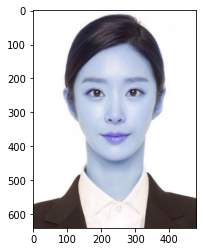

In [ ]:
my_image_path='/content/drive/MyDrive/01.19372617.1.jpg' #불러올 파일
  
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 변경
# opencv는 RGB 대신 BGR을 사용하기 때문에 RGB로 변경해주어야 한다.

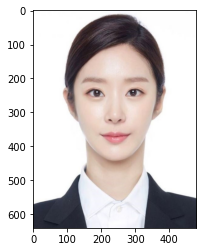

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

#3. 얼굴 검출 (Face Detection)

rectangles[[(111, 171) (379, 439)]]


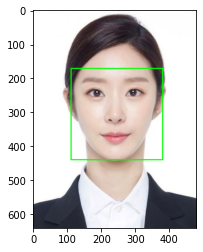

In [ ]:
# hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# 찾은 얼굴영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#4. 얼굴 랜드마크 (Face Landmark)

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다. face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.
*   Object keypoint estimation 알고리즘 : 객체 내부의 점을 찾는 기술
*   top-down : bounding box를 찾고 box 내부의 keypoint를 예측
*   bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
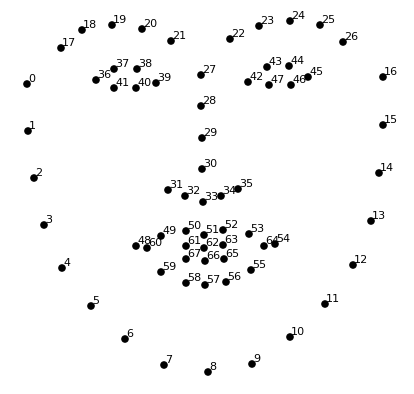

In [ ]:
# landmark 모델 불러오기
model_path = '/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))



68


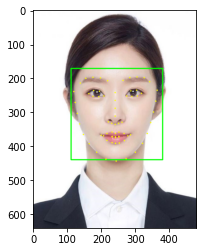

In [ ]:
# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#5. 스티커 적용하기

In [ ]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(240, 311)
(x,y) : (240,177)
(w,h) : (269,269)


In [ ]:
# 스티커 이미지 Read
import os
sticker_path = '/content/drive/MyDrive/5821890.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(269, 269, 3)
(x,y) : (106,-92)
(177, 269, 3)
(x,y) : (106,0)


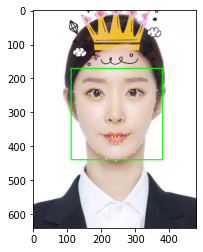

In [ ]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


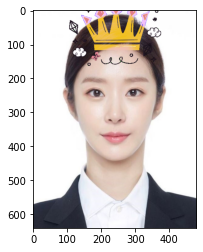

In [ ]:
# bounding box 제거 후 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#연습문제> 고양이 수염 스티커 만들기

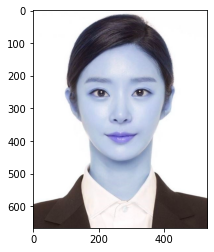

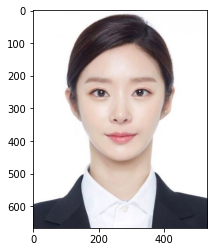

rectangles[[(141, 171) (409, 439)]]


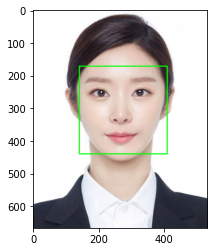

In [ ]:
# opencv로 이미지 불러오기
my_image_path='/content/drive/MyDrive/01.19372617.1.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
#img_bgr = cv2.resize(img_bgr, (img_bgr.shape[0] // 16 * 5, img_bgr.shape[1] // 9 * 5)) # Resize
img_bgr_orig = img_bgr.copy()
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

# 찾은 얼굴 영역 좌표
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

68


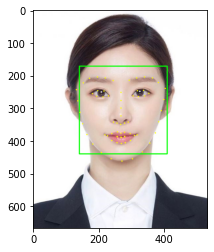

In [ ]:
# landmark model 불러오기
model_path = '/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # landmark 갯수 확인

# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [ ]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(268, 323)
(x,y) : (268,323)
(w,h) : (269,269)


(269, 269, 3)
(x,y) : (134,189)
(269, 269, 3)
(x,y) : (134,189)


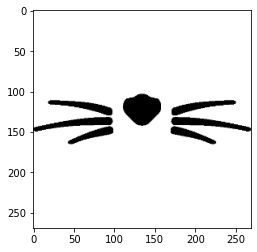

In [ ]:
# 스티커 이미지 Read
sticker_path = '/content/drive/MyDrive/24674.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

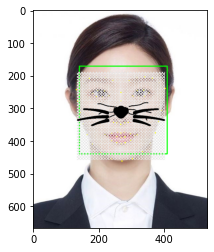

In [ ]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

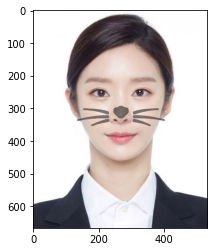

In [ ]:
# 불투명도 조절
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴 각도가 변하면 그에 맞게 스티커도 변형시켜주어야 해서 회전각도를 계산해야함

코를 중심으로 스티커를 적용시켰기 때문에 얼굴의 각도에 따라 회전시키면 됨. 따라서 27, 33번 landmark를 두 점으로 하는 벡터에 수직인 벡터를 구한 후 x축에 평행한 벡터와의 각을 구해야 함

<function matplotlib.pyplot.show>

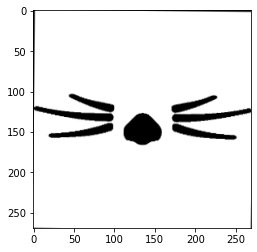

In [ ]:
# vector 계산
landmark = list_landmarks[0]
v1 = np.array([0, -1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

# 회전 변환
rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(angle), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

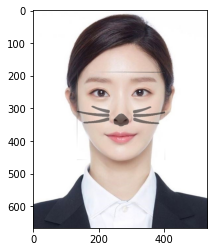

In [ ]:
# 회전 후 불투명도 조절
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()
